# Teacher Student - KD using Intermedia Regressor

##### Teacher Student Network Research
Framework adapted from Official Pytorch Knowledge Distillation Tutorial

Author:
Asad Amiruddin,
Harrison Maximillian Rush,
Huy N Ho

### Import library, datasets, loaders

In [1]:
%load_ext autoreload
%autoreload 2

# !git clone https://github.com/pytorch/captum
# %cd captum
# !git checkout "v0.2.0"
# !pip3 install -e .
# import sys
# sys.path.append('/content/captum')
# %cd ..

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from time import time
from torchvision import models
import captum
import gc
from captum import attr
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, DeepLift, LayerGradCam, LayerAttribution
from matplotlib import pyplot as plt
from captum.attr import visualization as viz
from torchvision import models

torch.manual_seed(42)

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_nonorm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataset_nonorm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_nonorm)

# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader_nonorm = torch.utils.data.DataLoader(test_dataset_nonorm, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define functions

In [2]:
class EarlyStopper:
    def __init__(self, patience=3, min_improv=0.01):
        self.patience = patience
        self.min_improv = min_improv
        self.counter = 0
        self.min_validation_loss = float('inf')

    def check_loss(self, validation_loss):
      # if validation loss improve by at least min_improv percentage, then
      # set min to current loss and reset the counter
        if validation_loss <  (self.min_validation_loss * (1 - self.min_improv)):
            self.min_validation_loss = validation_loss
            self.counter = 0
      # else if validation loss exceeds previous loss by the min_improv percentage,
      # start counter until hit patience
        elif validation_loss > (self.min_validation_loss * (1 + self.min_improv)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(model, train_loader, epochs, learning_rate, device, early_stop = False):
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses_epoch = []
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        losses = []
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            running_loss += float(loss.item())
        losses_epoch.append(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    del optimizer
    torch.cuda.empty_cache()
    gc.collect() 
    print(f"Training Time: {runtime:.3f}")
    return losses_epoch

def test(model, test_loader, device, to_cpu = False):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    if to_cpu: 
      model.to('cpu')
    inputs, labels = inputs.to('cpu'), labels.to('cpu')
    return accuracy

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, device, early_stop = False):
    print('Knowledge distillation training')
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    ce_loss_weight= 1 - soft_target_loss_weight
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    losses_epoch = []
    for epoch in range(epochs):
        running_loss = 0.0
        losses = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)


            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft target loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        losses_epoch.append(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")
    del optimizer
    torch.cuda.empty_cache()
    gc.collect() 
    return losses_epoch

def show_org_img(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(None , original_image, method="original_image",fig_size =(2,2), sign="absolute_value",
                              show_colorbar=True, title= title + " - Overlayed Gradient Magnitudes - " + img_label )
    return None

def show_saliency_map(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.to(device)
    model.eval()
    saliency = Saliency(model)
    gradients = saliency.attribute(input, target=labels[img_index].item())
    gradients = np.transpose(gradients.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(gradients, original_image , fig_size =(2,2),
                                 method="blended_heat_map", sign="absolute_value",
                              show_colorbar=True, title= title + " - Saliency - " + img_label )
    return gradients


def show_integrated_grad(model, data_loader,title , img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    ig = IntegratedGradients(model)

    model.zero_grad()
    ig = ig.attribute(input,target=labels[img_index])
    ig = np.transpose(ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(ig, original_image,fig_size =(2,2), method="blended_heat_map", sign="all",
                              show_colorbar=True, title= title + " - Overlayed Integrated Gradients - Image #" + img_label)
    
    return None

def layer_gradCAM(model, conv_layer, data_loader,title, img_index=3):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    layer_gradcam = LayerGradCam(model, conv_layer)
    attributions_lgc = layer_gradcam.attribute(input, target=img_index.item())
    # upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input.shape[2:])
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, (224, 224),interpolate_mode= "nearest")
    upsamp_attr_lgc = upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy()
    _ = viz.visualize_image_attr(upsamp_attr_lgc,original_image,fig_size =(2,2),show_colorbar=True, 
                             sign="all",
                             title=  title + " Layer GradCAM - Image #" + img_label)
    return None

def normalize_matrix(matrix):
    # Convert the matrix to a numpy array for easier manipulation
    matrix = np.array(matrix)

    # Calculate the sum of all elements in the matrix
    total_sum = np.sum(matrix)

    # Normalize the matrix by dividing each element by the total sum
    normalized_matrix = matrix / total_sum

    return normalized_matrix


def weighted_average_distance(matrix):
    # Normalize the matrix
    normalized_matrix = normalize_matrix(matrix)

    # Calculate the weighted center
    total_weight = np.sum(normalized_matrix)
    weighted_center_x = np.sum(normalized_matrix * np.arange(normalized_matrix.shape[0])[:, np.newaxis]) / total_weight
    weighted_center_y = np.sum(normalized_matrix * np.arange(normalized_matrix.shape[1])[np.newaxis, :]) / total_weight

    # Calculate the weighted distances
    weighted_distances = np.zeros_like(normalized_matrix, dtype=float)
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            weighted_distances[i, j] = normalized_matrix[i, j] * np.sqrt(
                (i - weighted_center_x) ** 2 + (j - weighted_center_y) ** 2)

    # Calculate the weighted average distance
    weighted_average_distance = np.sum(weighted_distances) / total_weight

    return weighted_average_distance

### Define deeper neural networks to be used as teachers.
Can have multiple teachers for comparison/experiments


### Load resnet50 model with finetuned weight as another teacher

In [3]:
teacher_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
teacher_resnet50.fc = nn.Linear(teacher_resnet50.fc.in_features, 10)
student_kd_inter_combinedteacher_resnet50 = teacher_resnet50.to(device)
#teacher_resnet50.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth",map_location=device  ))
teacher_resnet50.load_state_dict(torch.load("./trained_model/teacher_resnet50.pth",map_location=device))
test_accuracy_teacher = test(teacher_resnet50, test_loader, device)



Test Accuracy: 95.67%


### Define student network


In [4]:
# Define the student model
# class studentNN(nn.Module):
#     def __init__(self):
#         super(studentNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128 * 28 * 28, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 28 * 28)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


# Define another student - this is convNet_Tiny
class studentNN(nn.Module):
    def __init__(self):
        super(studentNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.conv3(x)  # Direct convolution
        x = self.relu(x)   # Activation
        x = self.pool2(x)   # Pooling
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model
# studentNN = studentNN().to(device)
# test_accuracy_student = test(studentNN, test_loader, device)

### Instantiate the 2 identical student nets

In [5]:

# Instantiate the lightweight network:
# We instantiate one more lightweight network model to compare their performances.
# Back propagation is sensitive to weight initialization,
# so we need to make sure these two networks have the exact same initialization.
torch.manual_seed(42)
learning_student = studentNN().to(device)


non_learning_student = studentNN().to(device)

# To ensure we have created a copy of the first network, we inspect the norm of its first layer.
# If it matches, then we are safe to conclude that the networks are indeed the same.

# Print the total number of parameters in each model:
total_params_teacher = "{:,}".format(sum(p.numel() for p in teacher_resnet50.parameters()))
print(f"DeepNN parameters: {total_params_teacher}")
total_params_non_learning_student = "{:,}".format(sum(p.numel() for p in non_learning_student.parameters()))
print(f"non_learning_student parameters: {total_params_non_learning_student}")
total_params_learning_student = "{:,}".format(sum(p.numel() for p in learning_student.parameters()))
print(f"learning_student parameters: {total_params_learning_student}")

DeepNN parameters: 23,528,522
non_learning_student parameters: 25,786,186
learning_student parameters: 25,786,186


### Train the students and compare to the one without teacher

In [6]:


load_non_learning_student_model_from_Gdrive = False   # need to be on Colab
load_non_learning_student_model_from_local_hard_drive = True

if load_non_learning_student_model_from_Gdrive:
    non_learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth"  ))
elif load_non_learning_student_model_from_local_hard_drive :
    non_learning_student.load_state_dict(torch.load("./trained_model/non_learning_student.pth",map_location=device))
else:
    #train non_learning_student on train dataset
    train(non_learning_student, train_loader, epochs=10, learning_rate=0.001, device=device)


load_learning_student_model_from_Gdrive = False   # need to be on Colab
load_learning_student_model_from_local_hard_drive = True

if load_learning_student_model_from_Gdrive:
    learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/learning_student.pth"  ))
elif load_learning_student_model_from_local_hard_drive :
    learning_student.load_state_dict(torch.load("./trained_model/learning_student.pth",map_location=device))
else:
    # Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
    train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)

test_accuracy_non_learning = test(non_learning_student, test_loader, device)
test_accuracy_learning_student = test(learning_student, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
# Result shouldn't be stellar because teacher's prediction can't beat ground truth here
print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_non_learning:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_learning_student:.2f}%")

Test Accuracy: 66.14%
Test Accuracy: 83.61%
Teacher accuracy: 95.67%
Student accuracy without teacher: 66.14%
Student accuracy with CE + KD: 83.61%


###Hyper tuning

In [7]:
# hyper parameters tuning
# lr_list = [0.002, 0.001, 0.0005]
# T_list = [1, 2, 3]
# soft_target_loss_weight_list = [0.1,  0.25, 0.3]
# 
# for lr in lr_list:
#   for T in T_list:
#     for stl in soft_target_loss_weight_list:
#       print('Learning Rate - T - Soft Target Loss Weight', lr, T, stl)
#       train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
#                                  train_loader=train_loader, epochs=10, learning_rate=lr,
#                                  T=T, soft_target_loss_weight=stl, device=device, early_stop = True)
#       test_accuracy_learning_student = test(learning_student, test_loader, device)



### Save trained models - only run after training on Colab

In [8]:
# IMPORTANT
# change the boolean below to True to save the trained model .pth file into your Google Drive
# only work if executing on Google Colab
save_model_to_Gdrive = False # need to be on Colab
save_model_to_local_drive = False
if save_model_to_Gdrive:
    torch.save(teacher_resnet50.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/learning_student.pth") # student after KD
elif save_model_to_local_drive:
    torch.save(teacher_resnet50.state_dict(), "./trained_model/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "./trained_model/learning_student.pth") # student after KD



In [9]:
torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_studen_test.pth") # non-learning student
torch.save(learning_student.state_dict(), "./trained_model/learning_student_test.pth") # student after KD

# Resnet and Intermediate Feature Transfer

Found a pretrained resnet32 on Cifar-10. 93% Accuracy reproduceable
https://github.com/chenyaofo/pytorch-cifar-models

In [10]:
from helper import *

We set hooks to provide the activation outputs at the specified layers

In [11]:
student_learner = studentNN().to(device)
student_non_learner = studentNN().to(device)
#student_first_stage = studentNN().to(device)
#student_first_stage.load_state_dict(torch.load("./trained_model/first_stage_student.pth"))
student_kd_inter_combined = studentNN().to(device)

teacher_layer= teacher_resnet50.layer3[0]
#teacher_activations = Hook(teacher_layer)

student_layer_kd_combine = student_kd_inter_combined.pool2

#student_activations = Hook(student_layer_kd_combine)

In [12]:
#print(student_activations.output.shape)
#print(teacher_activations.output.shape)
#print(teacher_resnet50.layer3[0])
#print(student_learner.conv3)
print(teacher_layer)
print(student_layer_kd_combine)

Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [13]:
student_layer_kd_combine = student_kd_inter_combined.pool2

loss_comb = train_kd_intermediate_combined(teacher=teacher_resnet50, 
                               student=student_kd_inter_combined,
                                train_loader=train_loader, 
                                epochs=25, 
                                learning_rate=0.0005,
                                T=3, 
                                soft_target_loss_weight=0.3, 
                                device=device, 
                                criterion_hint=hint_loss, 
                                student_layer=student_layer_kd_combine, 
                                teacher_layer=teacher_layer,
                                early_stop=True)

kd_combine_results = test(student_kd_inter_combined, test_loader, device)

Knowledge distillation training
Hook Set: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Hook Set: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


C:\Users\huyho\anaconda3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/25, Loss: 3.617075137774963
Epoch 2/25, Loss: 3.0044512132854413
Epoch 3/25, Loss: 2.786336273183603
Epoch 4/25, Loss: 2.589908960225332
Epoch 5/25, Loss: 2.4580026191213857
Epoch 6/25, Loss: 2.3503677149867768
Epoch 7/25, Loss: 2.2586565532952623
Epoch 8/25, Loss: 2.179870712177833
Epoch 9/25, Loss: 2.1208607391323273
Epoch 10/25, Loss: 2.069461898425656
Epoch 11/25, Loss: 2.0289572337094475
Epoch 12/25, Loss: 1.9712442751125911
Epoch 13/25, Loss: 1.9457502529749175
Epoch 14/25, Loss: 1.9184109893296382
Epoch 15/25, Loss: 1.8776890746772747
Epoch 16/25, Loss: 1.8430136033641102
Epoch 17/25, Loss: 1.8311090819975908
Epoch 18/25, Loss: 1.8043738957256308
Epoch 19/25, Loss: 1.7764579210135027
Epoch 20/25, Loss: 1.7568454205837396
Epoch 21/25, Loss: 1.7513639219581623
Epoch 22/25, Loss: 1.7218651613006202
Epoch 23/25, Loss: 1.7068445030075814
Epoch 24/25, Loss: 1.692086354850808
Epoch 25/25, Loss: 1.674027176159422
Training Time: 1330.711
Test Accuracy: 76.88%


###hyper tuning

In [15]:
# hyper parameters tuning
lr_list = [0.002, 0.001, 0.0008, 0.0005]
T_list = [1, 2, 3]
soft_target_loss_weight_list = [0.1,  0.25, 0.5, 0.7]

for lr in lr_list:
  for T in T_list:
    for stl in soft_target_loss_weight_list:
      print('Learning Rate - T - Soft Target Loss Weight', lr, T, stl)
      loss_comb = train_kd_intermediate_combined(teacher=teacher_resnet50, 
                               student=student_kd_inter_combined,
                                train_loader=train_loader, 
                                epochs=10, 
                                learning_rate=lr,
                                T=T, 
                                soft_target_loss_weight=stl, 
                                device=device, 
                                criterion_hint=hint_loss, 
                                student_layer=student_layer_kd_combine, 
                                teacher_layer=teacher_layer,
                                early_stop=True)
      kd_combine_results = test(student_kd_inter_combined, test_loader, device)

torch.save(student_kd_inter_combined.state_dict(), "./trained_model/student_kd_inter_combined.pth") # student after KD

Learning Rate - T - Soft Target Loss Weight 0.002 1 0.1
Knowledge distillation training
Hook Set: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Hook Set: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Epoch 1/10, Loss: 1.1385519631073604
Epoch 2/10, Loss: 1.0965215

###Visualize the student model intermediate layers

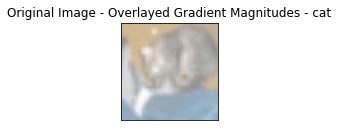

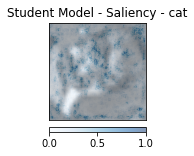

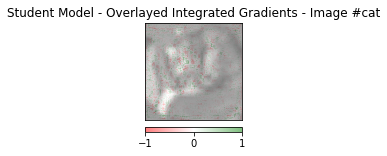

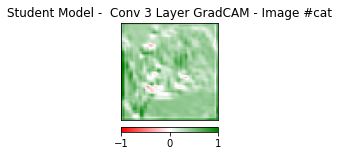

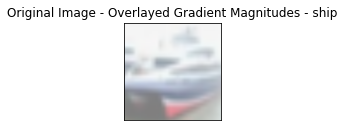

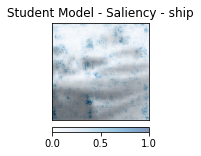

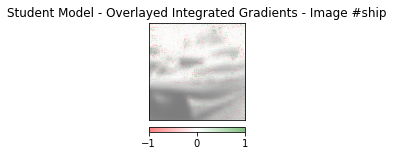

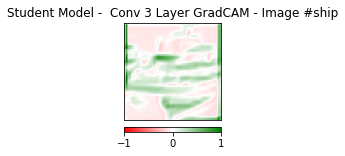

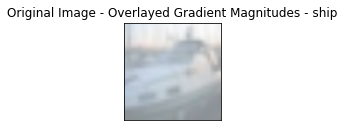

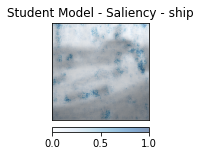

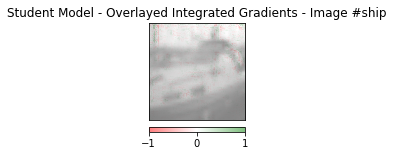

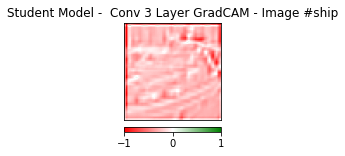

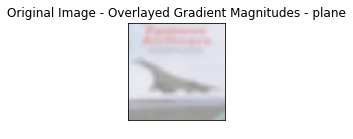

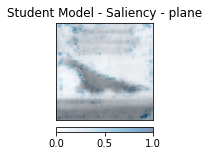

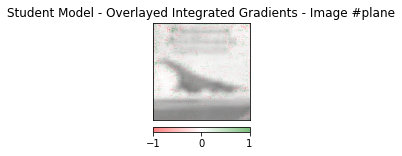

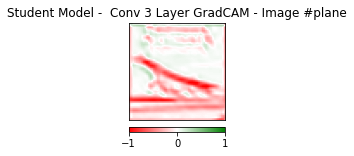

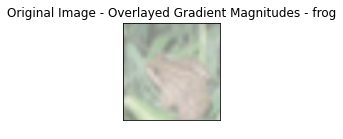

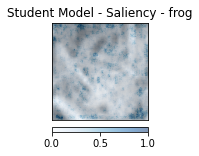

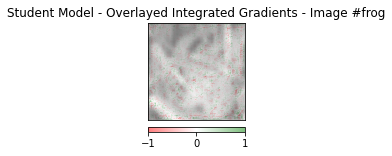

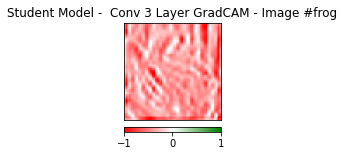

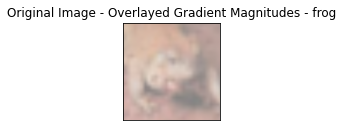

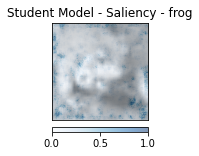

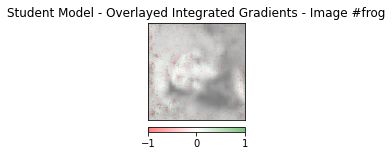

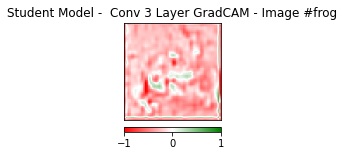

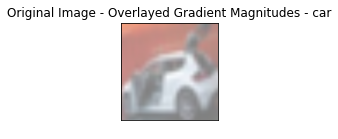

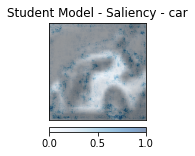

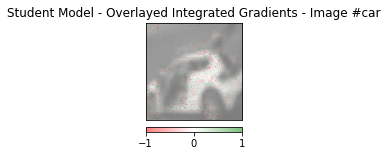

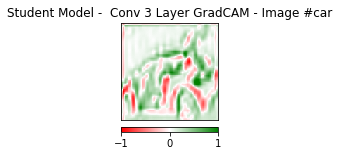

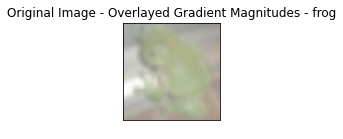

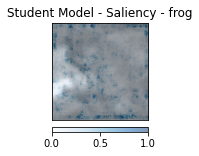

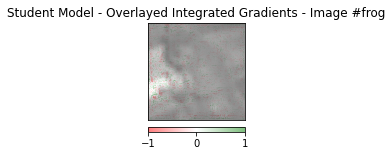

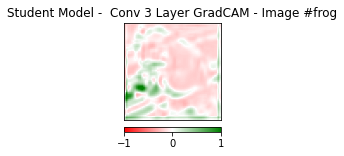

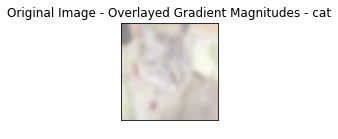

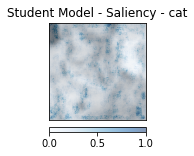

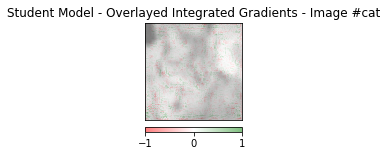

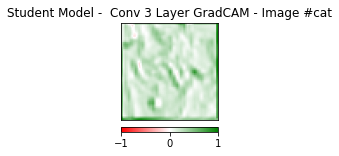

Weighted Average Distance Learning: [83.15434165 85.70220754 87.39352546 88.83176747 87.77527871 91.60399019
 85.67587864 86.22598688 88.18909964]
here


In [41]:

student_kd_inter_combined.load_state_dict(torch.load("./feature_transfer_models/combined_kd_inter.pth"))
img_index_list = np.arange(0,9) 
avg_distance_learning_student = np.empty((0,)) 
for img_index in img_index_list:  
    show_org_img(model = student_kd_inter_combined, data_loader = test_loader_nonorm,title = 'Original Image', img_index=img_index) 
    
    saliency_learning_student = show_saliency_map(model = student_kd_inter_combined, data_loader = test_loader_nonorm,title = 'Student Model', img_index=img_index) 
    
    show_integrated_grad(model = student_kd_inter_combined, data_loader = test_loader_nonorm,title = 'Student Model', img_index=img_index) 
     
    model = student_kd_inter_combined
    conv_layer = model.conv3
    layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Student Model -  Conv 3', img_index=img_index)
      
    saliency_learning_student = saliency_learning_student.mean(axis = (2))
    saliency_learning_student_mean = weighted_average_distance(saliency_learning_student)
    avg_distance_learning_student = np.append(avg_distance_learning_student,saliency_learning_student_mean) 
      
print("Weighted Average Distance Learning:", avg_distance_learning_student) 


###Model resilience to disruption

In [43]:
from torchvision.transforms import InterpolationMode

noise_type = (transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
              transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
              transforms.AugMix(severity= 2,mixture_width=2, chain_depth  = - 1,
                                alpha  = 1.0, all_ops  = True,
                                interpolation = InterpolationMode.BILINEAR,
                                fill = None))

for noise in noise_type:
  print(noise)


  transform_noisy = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          noise,
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  test_dataset_noisy = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_noisy)
  test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=128, shuffle=False, num_workers=2)

 
  test_accuracy_learning_student = test(student_kd_inter_combined, test_loader_noisy, device)
 
 
  print(f"Student accuracy : {test_accuracy_learning_student:.2f}%")

GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
Files already downloaded and verified
Test Accuracy: 75.12%
Student accuracy : 75.12%
ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
Files already downloaded and verified
Test Accuracy: 71.23%
Student accuracy : 71.23%
AugMix(severity=2, mixture_width=2, chain_depth=-1, alpha=1.0, all_ops=True, interpolation=InterpolationMode.BILINEAR, fill=None)
Files already downloaded and verified
Test Accuracy: 70.90%
Student accuracy : 70.90%


In [15]:
torch.save(student_kd_inter_combined.state_dict(), "./feature_transfer_models/combined_kd_inter.pth")
student_kd_inter_combined.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [16]:
loss_reg = train(student_non_learner, train_loader, epochs=25, learning_rate=0.001, device=device)
non_learner_results = test(student_non_learner, test_loader, device)

Epoch 1/25, Loss: 1.8506274342232043
Epoch 2/25, Loss: 1.6497776907728152
Epoch 3/25, Loss: 1.560627613226166
Epoch 4/25, Loss: 1.4876102023112499
Epoch 5/25, Loss: 1.4173098912324442
Epoch 6/25, Loss: 1.3741977852018898
Epoch 7/25, Loss: 1.3212317020996758
Epoch 8/25, Loss: 1.2882204552745575
Epoch 9/25, Loss: 1.2624751201371098
Epoch 10/25, Loss: 1.2389291142258803
Epoch 11/25, Loss: 1.2149930200003602
Epoch 12/25, Loss: 1.2026612409545332
Epoch 13/25, Loss: 1.189626785190514
Epoch 14/25, Loss: 1.1728183747557424
Epoch 15/25, Loss: 1.1540919742011049
Epoch 16/25, Loss: 1.14464956628697
Epoch 17/25, Loss: 1.127496109746606
Epoch 18/25, Loss: 1.1203801772173714
Epoch 19/25, Loss: 1.1188102416370227
Epoch 20/25, Loss: 1.109633812056783
Epoch 21/25, Loss: 1.0954199925712917
Epoch 22/25, Loss: 1.0896034852013259
Epoch 23/25, Loss: 1.088894392675756
Epoch 24/25, Loss: 1.0848283592392416
Epoch 25/25, Loss: 1.0730243448711112
Training Time: 791.708
Test Accuracy: 73.00%


In [17]:
torch.save(student_non_learner.state_dict(), "./feature_transfer_models/student_non_learner.pth")
student_non_learner.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [18]:
loss_kd = train_knowledge_distillation(teacher=teacher_resnet50, student=student_learner,
                                 train_loader=train_loader, epochs=25, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)
learner_results__ = test(student_learner, test_loader, device)

Knowledge distillation training
Epoch 1/25, Loss: 3.471830441823701
Epoch 2/25, Loss: 2.9528865783720675
Epoch 3/25, Loss: 2.732199039605572
Epoch 4/25, Loss: 2.574018638762062
Epoch 5/25, Loss: 2.418858224168763
Epoch 6/25, Loss: 2.3193871645671327
Epoch 7/25, Loss: 2.2150679811492298
Epoch 8/25, Loss: 2.141400782653438
Epoch 9/25, Loss: 2.0774258341630705
Epoch 10/25, Loss: 2.024449896324626
Epoch 11/25, Loss: 1.9723700672159414
Epoch 12/25, Loss: 1.9344002035877588
Epoch 13/25, Loss: 1.8927307211224684
Epoch 14/25, Loss: 1.840271615921079
Epoch 15/25, Loss: 1.8209870157339383
Epoch 16/25, Loss: 1.7871066380644698
Epoch 17/25, Loss: 1.7609091905681677
Epoch 18/25, Loss: 1.7353958132321878
Epoch 19/25, Loss: 1.7143668433284516
Epoch 20/25, Loss: 1.7025859694346748
Epoch 21/25, Loss: 1.6777660651585025
Epoch 22/25, Loss: 1.6551008815960506
Epoch 23/25, Loss: 1.6415573328047457
Epoch 24/25, Loss: 1.6180024552528205
Epoch 25/25, Loss: 1.6018365743520009
Training Time: 1274.360
Test Accur

In [19]:
torch.save(student_learner.state_dict(), "./feature_transfer_models/student_learner.pth")
student_learner.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [20]:
torch.cuda.memory_allocated()

317692928

In [21]:
import gc


del student_learner
del student_non_learner
del student_kd_inter_combined

torch.cuda.empty_cache()  # Clear memory cache

# Collect garbage
gc.collect()

127

In [22]:
total_losses = []
total_losses.append(loss_comb)
total_losses.append(loss_reg)
total_losses.append(loss_kd)
acc = []
acc.append(kd_combine_results)
acc.append(learner_results__)
acc.append(non_learner_results)

In [23]:
print(total_losses)
print(acc)

[[3.6154169036299373, 2.9961852612702744, 2.775133975631441, 2.579025615511648, 2.4411173662566164, 2.3436700175790226, 2.2581371913480637, 2.1684177412706265, 2.121052616697443, 2.0591503329899, 2.0216385857833314, 1.9748224425498786, 1.9451103091544812, 1.912837991019344, 1.8846594613531362, 1.8528385781266195, 1.8414557028914351, 1.8115159370710172, 1.7869312604674903, 1.7678608467511814, 1.752542046024976, 1.740666284890431, 1.7247576362946455, 1.6997945387954907, 1.6931475120432236], [1.8506274342232043, 1.6497776907728152, 1.560627613226166, 1.4876102023112499, 1.4173098912324442, 1.3741977852018898, 1.3212317020996758, 1.2882204552745575, 1.2624751201371098, 1.2389291142258803, 1.2149930200003602, 1.2026612409545332, 1.189626785190514, 1.1728183747557424, 1.1540919742011049, 1.14464956628697, 1.127496109746606, 1.1203801772173714, 1.1188102416370227, 1.109633812056783, 1.0954199925712917, 1.0896034852013259, 1.088894392675756, 1.0848283592392416, 1.0730243448711112], [3.47183044

In [24]:
student_first_stage = studentNN().to(device)

In [25]:
student_first_stage = studentNN().to(device)
student_layer_first_stage = student_first_stage.pool2
loss_first_stage = train_first_stage(train_loader, 
                                    student_first_stage, 
                                    teacher_resnet50, 
                                    hint_loss,
                                    epochs=25, 
                                    learning_rate=0.001, 
                                     student_layer=student_layer_first_stage, 
                                      teacher_layer=teacher_layer )

Hook Set: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Hook Set: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Epoch 1/25, Loss: 0.00393114285543561
Epoch 2/25, Loss: 0.00038152345223352313
Epoch 3/25, Loss: 9.978277375921607e-05
Epoch 4/25, Loss: 9.7304488008376

In [ ]:
loss_split_kd = train_knowledge_distillation(teacher=teacher_resnet50, student=student_first_stage,
                                 train_loader=train_loader, epochs=25, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)
first_stage_results = test(student_first_stage, test_loader, device)

Knowledge distillation training
Epoch 1/25, Loss: 3.650943965863084
Epoch 2/25, Loss: 3.1947130236174446
Epoch 3/25, Loss: 2.9594571395298406
Epoch 4/25, Loss: 2.80267552585553
Epoch 5/25, Loss: 2.6864504765366655
Epoch 6/25, Loss: 2.5754935814596505
Epoch 7/25, Loss: 2.4947998194438417
Epoch 8/25, Loss: 2.4225067089280814
Epoch 9/25, Loss: 2.3458607632790685


In [ ]:
torch.save(student_first_stage.state_dict(), "./feature_transfer_models/student_2_stage.pth")
student_first_stage.to('cpu')

In [ ]:

print(f"Student accuracy without teacher: {non_learner_results:.2f}%")
print(f"Student accuracy with CE + KD: {learner_results__:.2f}%")
print(f"Student accuracy with First Stage: {first_stage_results:.2f}%")
print(f"Student accuracy with Combined KD: {kd_combine_results:.2f}%")

In [ ]:
total_losses = []
total_losses.append(loss_comb)
total_losses.append(loss_reg)
total_losses.append(loss_kd)
total_losses.append(loss_split_kd)
acc = []
acc.append(kd_combine_results)
acc.append(learner_results__)
acc.append(non_learner_results)
acc.append(first_stage_results)

In [ ]:
print(total_losses)

In [ ]:



model_names = ['Combined Training', 'Regular Training', 'CE Loss KD', 'Split Training']

total_losses_norm = normalize_losses(total_losses)
plot_normalized_losses(total_losses_norm, model_names)


In [ ]:
from helper import *

In [ ]:
print(acc)
plot_model_accuracies(model_names, acc)

In [ ]:
student_test_first_stage = studentNN().to(device)
student_layer = student_test_first_stage.pool2
test_hook_s = Hook(student_layer)
test_hook_t = Hook(teacher_layer)
acc = test(student_test_first_stage, test_loader, device)
print(acc)
acc = test(teacher_resnet50, test_loader, device)
print(acc)
print(test_hook_t.output.shape)
regressor_test = ConvolutionalRegressor2().to(device)
x = regressor_test(test_hook_t.output)
print(x.shape)
print(test_hook_s.output.shape)


In [ ]:
student_test_first_stage = studentNN().to(device)
train_first_stage(train_loader, 
                  student_test_first_stage, 
                  teacher_resnet50, 
                  hint_loss, 
                  10, 
                  learning_rate=0.001, 
                  student_layer=student_layer_kd_combine, 
                  teacher_layer=teacher_layer)
test(student_test_first_stage, test_loader, device)

First stage training optimizes up to the hidden layer specified earlier, and uses the loss between teacher and student activations. Afterwards, we continue with the regular training routine

## RESNET18 Student

In [ ]:
from torchvision import models 


In [ ]:
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.6

In [6]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

NameError: name 'device' is not defined

In [ ]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('trained_model/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)